In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [61]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [62]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [63]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ]),
}

In [64]:
data_dir = 'kflowers'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

In [65]:
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [66]:
print(dataset_sizes)

{'train': 500, 'val': 264}


In [67]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [68]:
import torch.nn.functional as F

In [69]:
class ImageClassification(nn.Module):

    def train_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)

        return {'val_loss': loss.detach(), 'val_acc': acc}


    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}


    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [70]:
class Net(ImageClassification):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=7)

        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7)

        self.linear1 = nn.Linear(3872, 120)
        self.linear2 = nn.Linear(120, 32)
        self.linear3 = nn.Linear(32, 5)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = torch.flatten(x, 1)

        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))

        x = self.linear3(x)

        return x


net = Net()

In [71]:
net

Net(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1))
  (linear1): Linear(in_features=3872, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=5, bias=True)
)

In [72]:
from torchsummary import summary

summary(net, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 58, 58]           2,368
         MaxPool2d-2           [-1, 16, 29, 29]               0
            Conv2d-3           [-1, 32, 23, 23]          25,120
         MaxPool2d-4           [-1, 32, 11, 11]               0
            Linear-5                  [-1, 120]         464,760
            Linear-6                   [-1, 32]           3,872
            Linear-7                    [-1, 5]             165
Total params: 496,285
Trainable params: 496,285
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.67
Params size (MB): 1.89
Estimated Total Size (MB): 2.61
----------------------------------------------------------------


In [73]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [74]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)



def train(epochs, model, train_loader, val_loader, optimizer_name):

    history = []
    for epoch in range(epochs):

        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.train_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer_name.step()
            optimizer_name.zero_grad()


        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [83]:
hist = train(epochs=10, model=net, train_loader=dataloaders['train'],
             val_loader=dataloaders['val'], optimizer_name=optimizer)

Epoch [0], train_loss: 0.8228, val_loss: 1.4107, val_acc: 0.5000
Epoch [1], train_loss: 0.7908, val_loss: 1.5560, val_acc: 0.4735
Epoch [2], train_loss: 0.7689, val_loss: 1.3676, val_acc: 0.5644
Epoch [3], train_loss: 0.7463, val_loss: 1.4110, val_acc: 0.5341
Epoch [4], train_loss: 0.6749, val_loss: 1.6065, val_acc: 0.5000
Epoch [5], train_loss: 0.6608, val_loss: 1.6264, val_acc: 0.5114
Epoch [6], train_loss: 0.6399, val_loss: 1.8147, val_acc: 0.5227
Epoch [7], train_loss: 0.5501, val_loss: 1.9503, val_acc: 0.4583
Epoch [8], train_loss: 0.4998, val_loss: 1.9616, val_acc: 0.5265
Epoch [9], train_loss: 0.5785, val_loss: 1.7117, val_acc: 0.5303


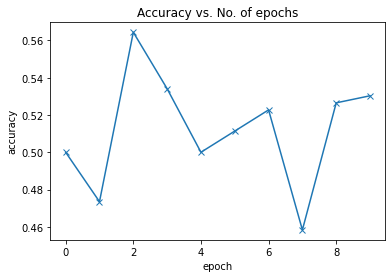

In [84]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    

plot_accuracies(hist)

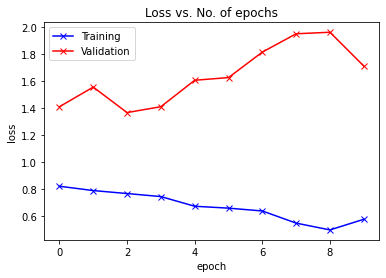

In [85]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

plot_losses(hist)

In [87]:
FILE = "model_pytorch.pth"
torch.save(net, FILE)

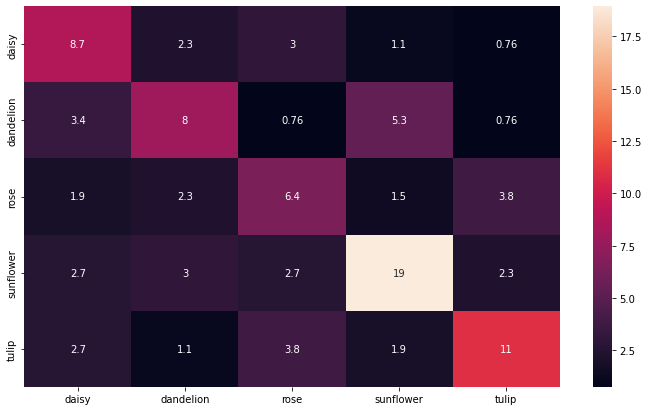

In [89]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

classes = class_names
model = torch.load('model_pytorch.pth') # model path 

y_pred = []
y_true = []

# iterate over val data
for inputs, labels in dataloaders['val']:
    output = model(inputs)  # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output)  # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels)  # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix) * 100, index=[i for i in classes],
                     columns=[i for i in classes])
plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, annot=True)

plt.show()